## Modified Python version of Gardner's lab tutorial on a channel response model using simulated tactile stimuli of frequencies: 100-340 Hz: 100, 130, 160, 190, 220, 250, 280, 310, 340.

- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

#### Created by Daniela del Río, https://github.com/DanidelRio

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
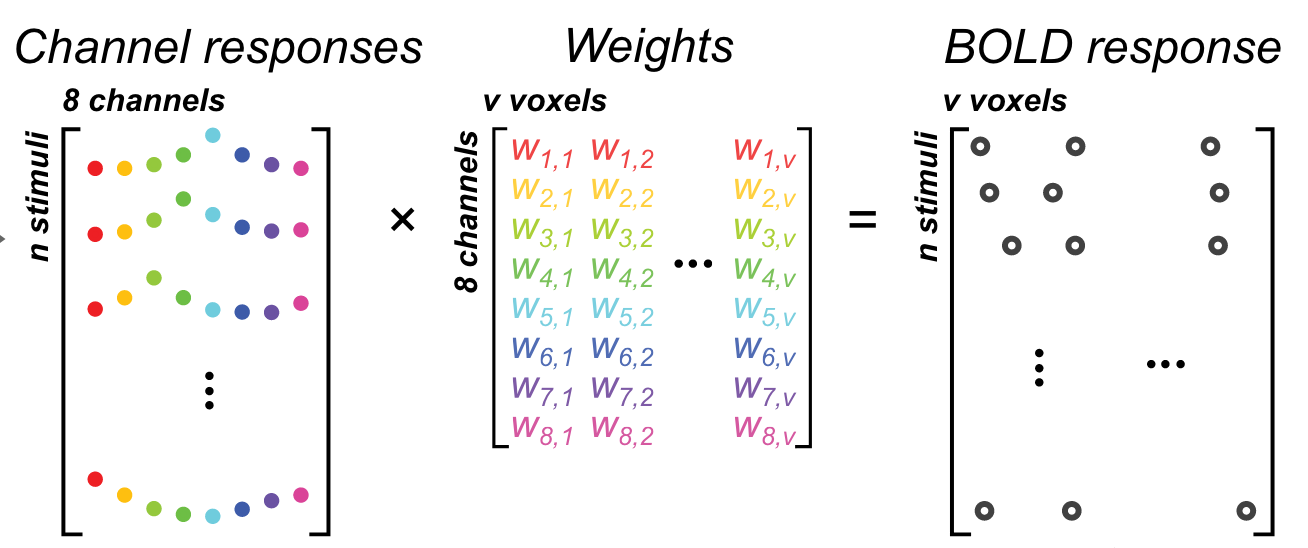

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

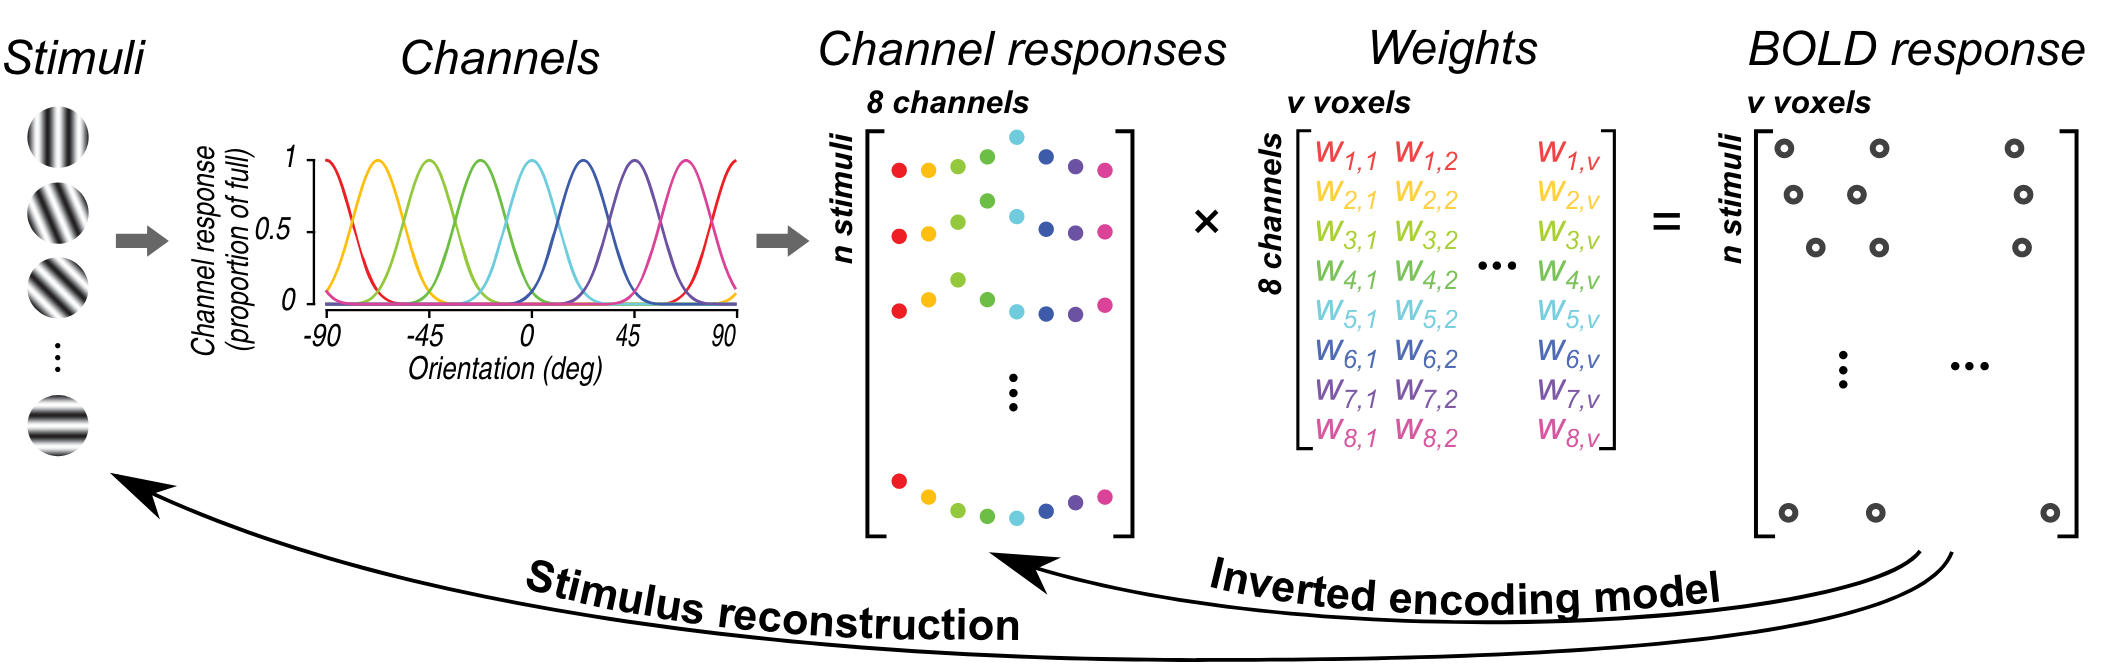
See Gardner and Liu, 2018.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from scipy.stats import multivariate_normal, pearsonr, ttest_ind
from scipy.optimize import curve_fit

### Create simulated stimuli, channel responses [C] and BOLD responses [B]

Tactile frequencies: 100, 130, 160, 190, 220, 250, 280, 310.

In [2]:
# Function that simulates BOLD response [B] with a gaussian function.
def simulate_data(nStimuli = 9, nRepeats = 20, nNeurons=105, sigma=10, nVoxels=50,
                  noiseStandardDeviation = 0.05):
    
    # Simulating tactile stimuli
    tactile_stimuli = [i*30+100 for i in range(nStimuli)]
    stimuli = np.asarray([[tactile_stimuli[i] for k in range(nRepeats)] for i in range(len(tactile_stimuli))]).reshape(1,nStimuli*nRepeats)
    stimuli = np.round(stimuli)
    stimuli = stimuli.astype(np.int64)

    # Simulating neural response
    neurons = np.arange(0, nNeurons)
    frequency_range = np.arange(100, 341) # Assuming there are neurons tuned from 100-309 Hz frequencied
    neuralResponse = np.zeros((len(neurons), len(frequency_range)))

    # Loop over each neuron tuning function
    for iNeuron in range(len(neurons)): # 0-90 neurons

        orientPreference = frequency_range[iNeuron*2] # 100-310 Hz in 2 Hz steps
        # Instead of a von Mises function, using a gaussian,
        # Inputs: x=orientations, mu=orientationPreference, sigma
        neuralResponse[iNeuron,:] = (1/ np.sqrt(2*np.pi*sigma**2))*np.exp(-(frequency_range-orientPreference)**2/(2*sigma**2))
        neuralResponse[iNeuron,:] = neuralResponse[iNeuron,:] / np.max(neuralResponse[iNeuron,:]) #np.abs(np.max(neuralResponse[iNeuron,:]) - np.min(neuralResponse[iNeuron,:]))
    
    # Simulated weight matrix
    neuronToVoxelWeights = np.random.rand(nNeurons, nVoxels) # Uniformly distributed random numbers

    nTrials = nStimuli * nRepeats

    # Compute the voxelResponse, B
    voxelResponse = []

    for iTrial in range(nTrials): # 20*8 = 160
        # get the neural response to this stimulus, by indexing the correct column of the neuralResponse matrix
        thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]-100] # 1-D array, 90 elements

        # multiply this by the neuronToVoxelWeights to get the voxel response on this trial.
        # Note that you need to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
        voxelResponse.append(np.matmul(thisNeuralResponse.T, neuronToVoxelWeights))
    # NOTE: In one part of the code, thisNeuralResponse is transposed.
    # Question: What is the right way to think about this?
    # It doesn't matter. This is only creating the simulated BOLD response. It is not calculating anything.
    # For congruence with the Matlab code, I transposed it.
    voxelResponse = np.asarray(voxelResponse)
    
    # Scaling the reponse
    voxelResponse = voxelResponse / np.mean(voxelResponse)

    aux1, aux2 = voxelResponse.shape
    # add gaussian noise, trial-level noise.
    voxelResponse = voxelResponse + noiseStandardDeviation * np.random.randn(aux1, aux2)

    return stimuli, frequency_range, voxelResponse, neuralResponse

In [3]:
# make channel basis functions
def create_channel_basis(stimuli, nChannels = 9, exponent = 7, nStimuli = 9, nRepeats = 20):
    # Note the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    prefStimuli = [i*30+100 for i in range(nStimuli)] # prefOrientation

    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-prefStimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each trial
    nTrials = nStimuli * nRepeats # 160

    channelResponse = np.zeros((nTrials, nChannels)) # 160*8

    for iTrial in range(nTrials):
        channelResponse[iTrial, :] = channelBasis[stimuli[0][iTrial]-100,:]
        
    return channelBasis, channelResponse

In [4]:
# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
# Outputs: estimatedWeights, modelPrediction, estimatedChannelResponse,
#          testVoxelResponse, residualResponse, r2

def model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse, nFolds=2, nConsecutiveSameTrials = 20):
    
    # From here.
    nTrials = channelResponse.shape[0]   

    nHalfData = int(nTrials/nFolds)
    first_half_vec = np.zeros(nHalfData, np.int64)
    second_half_vec = np.zeros(nHalfData, np.int64)
    index = 0

    for k in range(int(nTrials/nConsecutiveSameTrials)):
        for i in range(10):
            first_half_vec[index] = 20*k + i
            second_half_vec[index] = 20*k + i + 10
            index += 1
    # Until here.

    # split VoxelResponse [B] into train and test
    trainVoxelResponse = voxelResponse[first_half_vec]
    testVoxelResponse = voxelResponse[second_half_vec]
    
    # Divides channelResponse [C] into 2
    C1 = channelResponse[first_half_vec]
    C2 = channelResponse[second_half_vec]
    
    # W_estimated
    # Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
    estimatedWeights = np.matmul(np.linalg.pinv(C1), trainVoxelResponse)
    
    # B_predicted, compute model prediction on test data
    modelPrediction = np.matmul(C2, estimatedWeights)
    # C_estimated, compute channel response from textVoxelResponses
    estimatedChannelResponse = np.matmul(testVoxelResponse, np.linalg.pinv(estimatedWeights))
    
    # compute residual
    residualResponse = testVoxelResponse - modelPrediction
    
    # compute r2
    r2 = 1 - np.var(residualResponse) / np.var(testVoxelResponse)

    return estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2

In [5]:
# Function that fits some model to the noise to obtain the most likely stimulus
def recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, stimuli_length, nVoxels,
                             estimatedWeights):
    
    # compute residual variance, note that this is a scalar
    residualVariance = np.var(residualResponse)

    # make this into a covariance matrix in which the diagonal contains the variance for each voxel
    # and off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(testVoxelResponse, 0)
    likelihood = np.zeros([nTestTrials, stimuli_length])

    # WHERE WOULD YOU CONSIDER TH ENTRIES OF FREQUENCY_SPACE
#     frequency_indices = np.asarray([i for i in range(frequency_len)])
    
    for iTrial in range(nTestTrials):

    # HERE: Perhaps the error comes from here on how likelihoods are computed.
    # Either from computing the predictedResponse or from fitting a multivariate gaussian
    # to each trial
      for iStimulus in range(stimuli_length): # 211 iterations
        # compute the mean voxel response predicted by the channel encoding model
        predictedResponse = np.matmul(channelBasis[iStimulus], estimatedWeights)
        # now use that mean response and the model covariance to estimate the probability
        # of seeing this orientation given the response on this trial
        
        mvnpdf = multivariate_normal.pdf(testVoxelResponse[iTrial], mean=predictedResponse,
                                         cov = modelCovar)
        likelihood[iTrial,iStimulus] = mvnpdf
        
    return likelihood

In [6]:
# Simulation for visualizing the recurrency plot
nStimuli = 9
nRepeats = 20

nNeurons = 105
sigma = 10
nVoxels = 300
noiseStandardDeviation = 0.3 # This could be 0.05 or 0.5

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 9
exponent = 7

stimuli, frequency_range, voxelResponse, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons,
                                            sigma, nVoxels, noiseStandardDeviation)
channelBasis, channelResponse = create_channel_basis(stimuli)


# Obtain the similarity plot
nTrials = stimuli.shape[1]
matrix = np.zeros([nTrials, nTrials])

for i in range(nTrials):
    for j in range(nTrials):
        matrix[i, j] = pearsonr(voxelResponse[i,:], voxelResponse[j,:])[0]

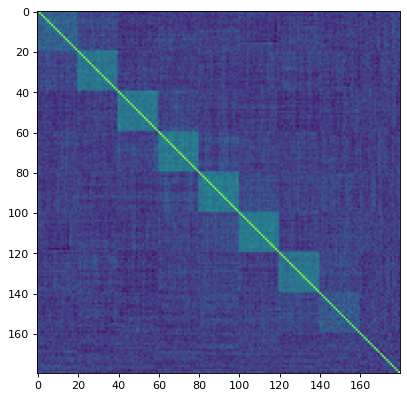

In [7]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(matrix)
plt.show()

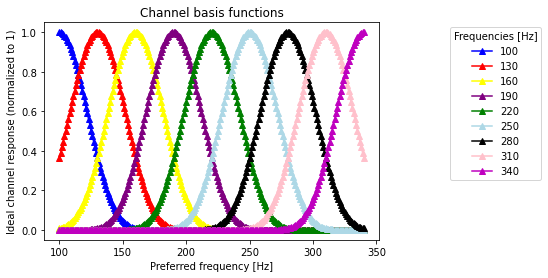

In [8]:
# Plot the mean estimatedChannelResponse for each stimulus type 
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink', 'm']
# prefOrientation = [i*180/nChannels for i in range(nChannels)]

for i in range(nStimuli):
#     plt.plot(prefOrientation, means, c=colors[i], label="Preferred orientation")

    plt.plot(frequency_range, channelBasis[:,i], c=colors[i], marker="^", label=stimuli[0,i*20])
    
#     likelihood_means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension
#     plt.plot(likelihood_means, c = colors[i], marker=".", label = "Stimulus likelihood")
    
plt.title("Channel basis functions")
plt.xlabel('Preferred frequency [Hz]')
plt.ylabel('Ideal channel response (normalized to 1)')
# plt.title("r2="+str(round(r2, 4)))
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
plt.show()

In [9]:
# To run the simulation with stimuli_alt
channelBasis, channelResponse = create_channel_basis(stimuli, nChannels, exponent)

# # Model fit with folds
estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse)
print(r2)

0.6747253015823265


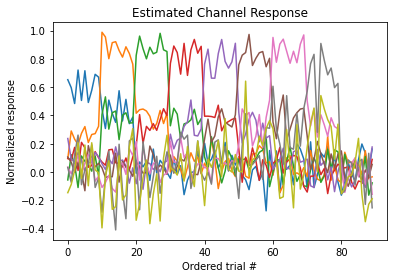

In [10]:
plt.plot(estimatedChannelResponse)
plt.xlabel('Ordered trial #')
plt.ylabel('Normalized response')
plt.title('Estimated Channel Response')
plt.show()

Note the amount of noise in the `noiseStandardDeviation` affects the r^2 value and the estimated channel responses.

For example, when the noise is 0.5, the estimated channel responses are not recovered.

J: Exactly what transformation is going on here?

In [11]:
frequency_space = np.asarray([i*2+100 for i in range(121)])
print(frequency_space)
print(frequency_space.shape)

[100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134
 136 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170
 172 174 176 178 180 182 184 186 188 190 192 194 196 198 200 202 204 206
 208 210 212 214 216 218 220 222 224 226 228 230 232 234 236 238 240 242
 244 246 248 250 252 254 256 258 260 262 264 266 268 270 272 274 276 278
 280 282 284 286 288 290 292 294 296 298 300 302 304 306 308 310 312 314
 316 318 320 322 324 326 328 330 332 334 336 338 340]
(121,)


In [12]:
# To run the simulation with stimuli_alt
channelBasis, channelResponse = create_channel_basis(stimuli, nChannels, exponent)

# # Model fit with folds
estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse)
print("r2",r2)

frequency_len = 241

likelihood = recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, frequency_len, nVoxels, estimatedWeights)

r2 0.6747253015823265


In [13]:
# Obtaining probabilities, aka normalizing across trials
trials_length, frequencies_length = likelihood.shape

probability = np.zeros([trials_length, frequencies_length])

for trial_i in range(trials_length): # 890 iterations
    
    upper_lim = max(likelihood[trial_i,:])
    lower_lim = min(likelihood[trial_i,:])
    
    # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
    probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

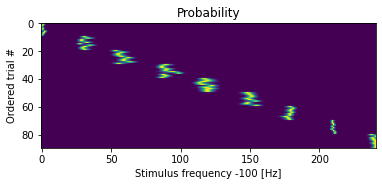

In [14]:
plt.imshow(probability)
plt.xlabel('Stimulus frequency -100 [Hz]')
plt.ylabel('Ordered trial #')
plt.title('Probability')
plt.show()

# What is the most likely stimulus for a given trial?

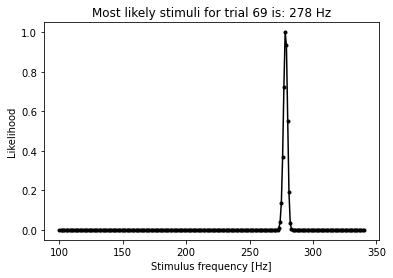

In [15]:
# Single trial, 80 possible trials
trial_i = 69
likely_stimuli = probability[trial_i,:].argmax()
tactile_stimuli = [i+100 for i in range(241)]

label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(likely_stimuli+100)+" Hz"

plt.plot(tactile_stimuli, probability[trial_i,:], marker=".", c="k")
plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Likelihood')
plt.show()

# Fitting a gaussian to each trial
Obtaining mu and sigma.


In [16]:
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))

[0.88832969 0.70843071 1.79801278]


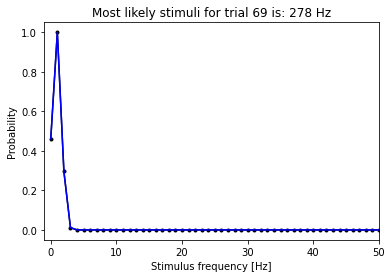

In [17]:
# What if we fit the gaussian only around the maximum values?

# Single trial
trial_i = 8

# likely_stimuli = probability[trial_i,:].argmax()
# xdata = [i+100 for i in range(211)]
xdata = [i for i in range(241)]

ydata = probability[trial_i,:]

p0 = [probability[trial_i,:].argmax(), 0.5, 1]

# Using non-lionear least squares to fit the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
print(gaussian_fit[0])
mean, sigma, amplitude = gaussian_fit[0]

# label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(round(mean))+"°"

plt.plot(probability[trial_i,:], marker=".", c="k")

plt.plot(xdata, gaussian(xdata, mean, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Probability')
plt.xlim([-1,50])
# plt.xlim([125,175])
plt.show()

[27.62051964  1.35522114  3.58999835]


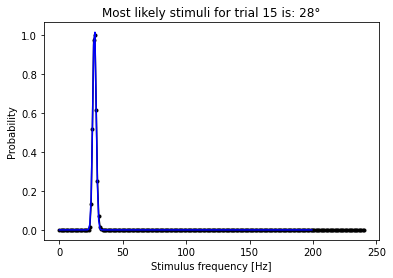

In [18]:
# Modifying the domain space to fit the curve only around the non-zero values
# Indices are offset from frequencies (x-axis) by 100
trial_i = 15

init_index = 0
end_index = 200

xdata = [i+init_index for i in range(end_index-init_index)]

ydata = probability[trial_i, init_index:end_index]

# When using the curve fit, it is very important to give an approximate estimate!!
p0 = [probability[trial_i,init_index:end_index].argmax()+init_index, 0.5, 1]

# Using non-lionear least squares to fit the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
print(gaussian_fit[0])
mean, sigma, amplitude = gaussian_fit[0]

label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(round(mean))+"°"

plt.plot(probability[trial_i,:], marker=".", c="k")

plt.plot(xdata, gaussian(xdata, mean, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Probability')
# plt.xlim([50,75])
# plt.xlim([125,175])
plt.show()

### Can a gaussian be fitted to all the trials?
### If not, what are the trials where it cannot be fitted?
A gaussian cannot be fitted to any trials of the first stimulus condition, 100 Hz, indices 0-9. Additionally, the last trial condition, indices 70-79.
# Is there a common characteristic of these trials that you cannot fit a gaussian to?
Yes, all the stimulus conditions close to the boundaries.

This is because of how we defined the channel basis.

In [19]:
# Fitting a gaussian to all the trials
length, nfrequencies = probability.shape
means_vec = np.zeros(length)
sigmas_vec = np.zeros(length)
amplitudes_vec = np.zeros(length)

xdata = [i for i in range(nfrequencies)] # 211 frequencies, 100-310


for trial_i in range(0,length): # indices are from 10-69.
#     print(trial_i)
    ydata = probability[trial_i,:]
    p0 = [probability[trial_i,:].argmax(), 0.5, 1]

    try: # HERE!!!
        gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
    except RuntimeError:
        print("Error fitting gaussian in: ",trial_i)
        gaussian_fit = [['nan', 'nan', 'nan']]
        
    means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]

Error fitting gaussian in:  0


# What questions can we formulate that these gaussian-fitted likelihoods can answer?

### What are the values for the means, sigmas and amplitudes?

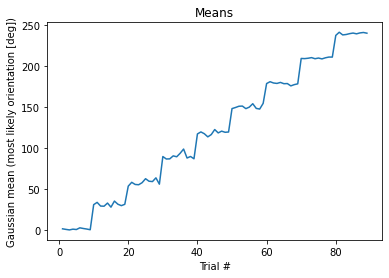

In [20]:
plt.plot(means_vec)
plt.title("Means")
plt.xlabel('Trial #')
plt.ylabel('Gaussian mean (most likely orientation [deg])')
plt.show()

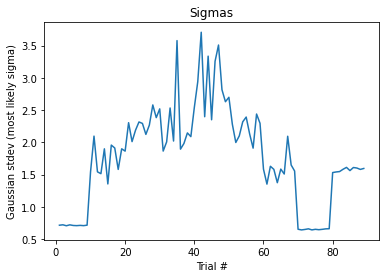

In [21]:
plt.plot(sigmas_vec)
plt.title("Sigmas")
plt.xlabel('Trial #')
plt.ylabel('Gaussian stdev (most likely sigma)')
plt.show()

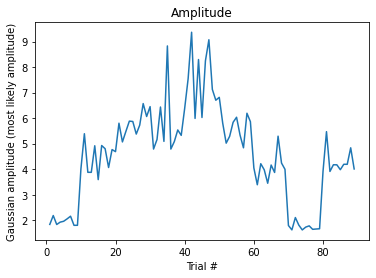

In [22]:
plt.plot(amplitudes_vec)
plt.title("Amplitude")
plt.xlabel('Trial #')
plt.ylabel('Gaussian amplitude (most likely amplitude)')
plt.show()

Create a violin plot of the decoded stimuli against the true stimuli.

What does the data show?

In [23]:
means_organized = [np.asarray(means_vec[10*i:10*i+10]) for i in range(9)]

In [24]:
auxiliary = [i+1 for i in range(nStimuli)]
tactile_stimuli = [i*30+100 for i in range(nStimuli)]

stimuli_aux = np.asarray([[auxiliary[i] for k in range(10)] for i in range(nStimuli)]).reshape(1, nStimuli*10)
stimuli_aux

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9]])

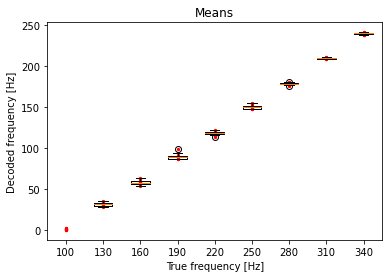

In [25]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# If a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(means_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, means_vec, s=5, c='r')

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Means")
plt.show()

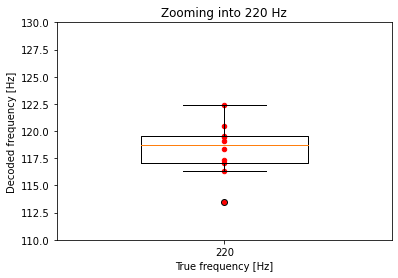

In [26]:
# Zooming into the previous plot

fig, ax = plt.subplots()

ax.boxplot(means_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, means_vec, s=20, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)

plt.ylim([110, 130])
plt.xlim([4.5, 5.5])

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Zooming into 220 Hz")
plt.show()

In [27]:
sigmas_organized = [np.asarray(sigmas_vec[10*i:10*i+10]) for i in range(nStimuli)]

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


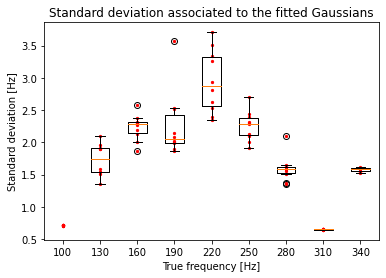

In [28]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, sigmas_vec, s=5, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)
# plt.ylim([-1, 5])

plt.hlines(np.mean(sigmas_organized), 0, 9, linestyle='dashed', colors = 'r')

# plt.ylim([20, 28])
# plt.xlim([1.5, 2.5])

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Standard deviation [Hz]')
plt.title("Standard deviation associated to the fitted Gaussians")
plt.show()

J: Idea of fitting a gaussian to every trial and then avergig.

# Putting everything together. If you wanted to run a single simulation until obtaining the means and sigmas from the gaussian fit, what lines of code would you need?

In [29]:
# Simulating data
nStimuli = 9
nRepeats = 20

nNeurons = 105
sigma = 10
nVoxels = 50
noiseStandardDeviation = 0.05 # This could be 0.05 or 0.5

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

stimuli, frequency_range, voxelResponse, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons,
                                            sigma, nVoxels, noiseStandardDeviation)

# Channel basis
channelBasis, channelResponse = create_channel_basis(stimuli, nChannels, exponent)

# Model fit with folds
estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse)

# Obtaining the likelihoods
frequency_len = 241
likelihood = recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, frequency_len, nVoxels, estimatedWeights)


# Obtaining probability vector, aka normalizing likelihood across trials
trials_length, frequencies_length = likelihood.shape
probability = np.zeros([trials_length, frequencies_length])

for trial_i in range(trials_length): # 80 iterations

    upper_lim = max(likelihood[trial_i,:])
    lower_lim = min(likelihood[trial_i,:])
    
    # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
    probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

In [39]:
xdata = [i for i in range(nfrequencies)] # frequencies: 0 to 240, shoudl it be 100-310?

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [31]:
# Fitting a gaussian to all the trials
length, nfrequencies = probability.shape
means_vec = np.zeros(length)
sigmas_vec = np.zeros(length)
amplitudes_vec = np.zeros(length)

xdata = [i for i in range(nfrequencies)] # 211 frequencies, 100-310

for trial_i in range(0,length): # indices are from 10-69.
    ydata = probability[trial_i,:]
    p0 = [probability[trial_i,:].argmax(), 0.5, 1]

    try: # HERE!!!
        gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
    except RuntimeError:
        print("Error fitting gaussian in: ",trial_i)
        gaussian_fit = [['nan', 'nan', 'nan']]
        
    means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]

Error fitting gaussian in:  2
Error fitting gaussian in:  4
Error fitting gaussian in:  6
Error fitting gaussian in:  72
Error fitting gaussian in:  89


Question. Until here, is the simulation doing what I want it to?

In the last trials, the sigmas have higher values. This might be related to the estimatedChannelResponses (Yellow curve in the following plot).

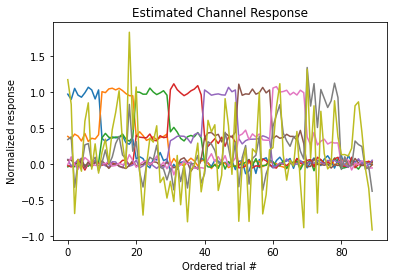

In [32]:
plt.plot(estimatedChannelResponse)
plt.xlabel('Ordered trial #')
plt.ylabel('Normalized response')
plt.title('Estimated Channel Response')
plt.show()

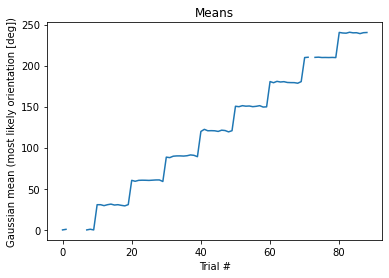

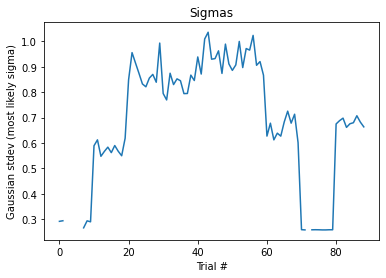

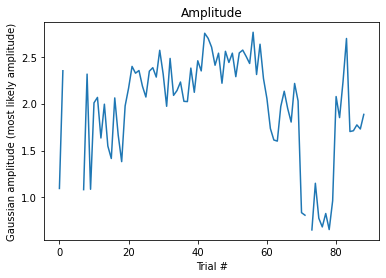

In [33]:
plt.plot(means_vec)
plt.title("Means")
plt.xlabel('Trial #')
plt.ylabel('Gaussian mean (most likely orientation [deg])')
plt.show()

plt.plot(sigmas_vec)
plt.title("Sigmas")
plt.xlabel('Trial #')
plt.ylabel('Gaussian stdev (most likely sigma)')
plt.show()

plt.plot(amplitudes_vec)
plt.title("Amplitude")
plt.xlabel('Trial #')
plt.ylabel('Gaussian amplitude (most likely amplitude)')
plt.show()

# The amplitudes to the fitted gaussians are not negative. Why are they negative in the following part of the code?

In [34]:
nfrequencies

241

In [35]:
gaussian(xdata, mean+100, sigma, amplitude)

array([6.15516391e-37, 2.19440621e-36, 7.74553609e-36, 2.70671790e-35,
       9.36465025e-35, 3.20772541e-34, 1.08782707e-33, 3.65241062e-33,
       1.21410538e-32, 3.99567566e-32, 1.30191049e-31, 4.19980456e-31,
       1.34132522e-30, 4.24127229e-30, 1.32774683e-29, 4.11520476e-29,
       1.26277123e-28, 3.83632122e-28, 1.15388441e-27, 3.43610716e-27,
       1.01304363e-26, 2.95696821e-26, 8.54519971e-26, 2.44486472e-25,
       6.92539429e-25, 1.94218784e-24, 5.39256033e-24, 1.48236738e-23,
       4.03435157e-23, 1.08704792e-22, 2.89988444e-22, 7.65895907e-22,
       2.00269983e-21, 5.18464505e-21, 1.32886007e-20, 3.37206961e-20,
       8.47170578e-20, 2.10718300e-19, 5.18908395e-19, 1.26513303e-18,
       3.05378706e-18, 7.29790759e-18, 1.72669259e-17, 4.04472262e-17,
       9.38036028e-17, 2.15380980e-16, 4.89612204e-16, 1.10193043e-15,
       2.45534866e-15, 5.41663063e-15, 1.18304790e-14, 2.55818818e-14,
       5.47670950e-14, 1.16081758e-13, 2.43593280e-13, 5.06085257e-13,
      

### Note that in the following cell, the amplitude of a fitted gaussian is negative.

In [37]:
trial_i = 87
means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i]

(240.10348165791063, 0.6821631610925263, 1.7297173483180228)

179.23157789122027 0.6778938760325349 1.803673122918392


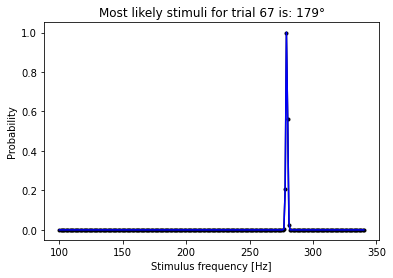

In [57]:
# Modifying the domain space to fit the curve only around the non-zero values
# Indices are offset from frequencies (x-axis) by 100
trial_i = 67

xdata = [i for i in range(nfrequencies)] # 211 frequencies, 100-310
xdata_real = [i+100 for i in range(nfrequencies)]

ydata = probability[trial_i, :]

# When using the curve fit, it is very important to give an approximate estimate!!
p0 = [probability[trial_i,:].argmax(), 0.5, 1]

# Using non-lionear least squares to fit the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
mean, sigma, amplitude = gaussian_fit[0]

print(mean, sigma, amplitude)
label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(round(mean))+"°"

plt.plot(xdata_real, probability[trial_i,:], marker=".", c="k")
plt.plot(xdata_real, gaussian(xdata_real, mean+100, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Probability')
# plt.xlim([300,375])
# plt.xlim([0,150])
plt.show()

The function `curve_fit` is not doing what I would expect it to.

I guess `curve_fit` is assuming the xdata is centered around 0. I do not know why when I consider the xdata to start in index 100, it starts throwing this error. So, the means need to be translated by 100 indices, just like the frequency indices themselves.

What if you were to use a mirror function of the data. In the extremes, replicate what already exists in the adjacent 50 stim frequencies, like a mirror.

In [71]:
# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
#         print(beginning)
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))

# TODO HERE AQUI
# IF the `curve_fit` function does not work as I expect it to with the mirrored edges, I will go ahead and use another funciton to fit a gaussian, or create my own function

The vector we are interested in flipping is the likelihoods.
The xdata can simply be augmented by more frequencies, 25 more on each side. So the 

In [72]:
nTestTrials, nfrequencies = probability.shape
nfrequencies

241

179.23157789122027 0.6778938760325349 1.803673122918392


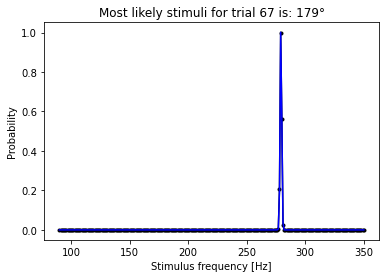

In [105]:
# Awesome, fitting a gaussian for a single trial.
# Incorporating the mirror function
# Note how the values for the xdata need to be modified.
# Indices are offset from frequencies (x-axis) by 100
trial_i = 67
cushion = 10

xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

ydata = probability[trial_i, :]
ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES

# When using the curve fit, it is very important to give an approximate estimate!!
p0 = [probability[trial_i,:].argmax(), 0.5, 1]

# Using non-lionear least squares to fit the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
gaussian_fit = curve_fit(gaussian, xdata, ydata_mirror, p0)
mean, sigma, amplitude = gaussian_fit[0]

print(mean, sigma, amplitude)
label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(round(mean))+"°"

plt.plot(xdata_real, ydata_mirror, marker=".", c="k")
plt.plot(xdata_real, gaussian(xdata_real, mean+100, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Probability')
# plt.xlim([300,375])
# plt.xlim([0,150])
plt.show()

In [107]:
# Trying out the mirror function to fit a gaussian to ALL the test trials.
# xdata_real = np.asarray([float(i) for i in range(nfrequencies+25*2)])
cushion = 10

xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

# Fitting a gaussian to all the test trials
nTestTrials, nfrequencies = probability.shape

means_vec = np.zeros(nTestTrials)
sigmas_vec = np.zeros(nTestTrials)
amplitudes_vec = np.zeros(nTestTrials)

# xdata = [float(i+100) for i in range(nfrequencies)] # THE BUG WAS HERE! OUR OG SPACE IS 100-340 HZ!

for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
    ydata = probability[trial_i, :]
    ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES

    p0 = [probability[trial_i,:].argmax(), 0.5, 1]

    try: # HERE!!!
        gaussian_fit = curve_fit(gaussian, xdata, ydata_mirror, p0) # I DO NOT KNOW IF THE ERROR IS HERE
#         gaussian_fit[0][0] += 100 
#         # gaussian takes: x, mu, sigma, amplitude
    except RuntimeError:
        print("Error fitting gaussian in: ",trial_i)
        gaussian_fit = [['nan', 'nan', 'nan']]

    means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]

Error fitting gaussian in:  72


After running the code for all the frequencies, when I run a single trial, the graph does not look like what it looks like when fitting for a single trial.

Is the code for running all the trials simultaneously doing it as I would expect it to?

If it is, is it a matter of how I am plotting it_

In [101]:
np.argmax(ydata_mirror) # 250
np.argmax(gaussian(xdata_real, mean+100, sigma, amplitude)) #190

190

240.5 0.726844508753276 2.3082966605090154


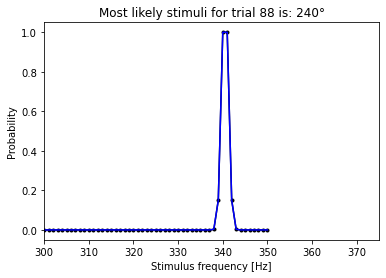

In [123]:
trial_i = 88
mean, sigma, amplitude = means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i]
ydata = probability[trial_i, :]
ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES

print(mean, sigma, amplitude)
label = "Most likely stimuli for trial " + str(trial_i) + " is: " + str(round(mean))+"°"

plt.plot(xdata_real, ydata_mirror, marker=".", c="k")
plt.plot(xdata_real, gaussian(xdata_real, mean+100, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Probability')
plt.xlim([300,375])
# plt.xlim([0,150])
plt.show()

# FUNCIONA!!
# MVC (most valued cell) is the following one!

In [126]:
# Fitting a gaussian to all the test trials
# Trying out the mirror function to fit a gaussian to ALL the test trials.
# xdata_real = np.asarray([float(i) for i in range(nfrequencies+25*2)])
cushion = 10

xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

# Fitting a gaussian to all the test trials
nTestTrials, nfrequencies = probability.shape

means_vec = np.zeros(nTestTrials)
sigmas_vec = np.zeros(nTestTrials)
amplitudes_vec = np.zeros(nTestTrials)

# xdata = [float(i+100) for i in range(nfrequencies)] # THE BUG WAS HERE! OUR OG SPACE IS 100-340 HZ!

for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
    ydata = probability[trial_i, :]
    ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES

    p0 = [probability[trial_i,:].argmax(), 0.5, 1]

    try: # HERE!!!
        gaussian_fit = curve_fit(gaussian, xdata, ydata_mirror, p0) # I DO NOT KNOW IF THE ERROR IS HERE
#         gaussian_fit[0][0] += 100 
#         # gaussian takes: x, mu, sigma, amplitude
    except RuntimeError:
        print("Error fitting gaussian in: ",trial_i)
        gaussian_fit = [['nan', 'nan', 'nan']]

    means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]
    
# plt.plot(xdata_real, ydata_mirror, marker=".", c="k")
# plt.plot(xdata_real, gaussian(xdata_real, mean+100, sigma, amplitude), c="b")

    # THESE MEANS ARE IN TEH RANGE 0-240 HZ.
# Outputs: means_vec, sigmas_vec, amplitudes_vec    

# Organizing the values for boxplots:
auxiliary = [i+1 for i in range(nStimuli)]
stimuli_aux = np.asarray([[auxiliary[i] for k in range(10)] for i in range(len(tactile_stimuli))]).reshape(1,round(nStimuli*nRepeats/2))

stimuli_organized = stimuli.reshape(nStimuli,nRepeats)
means_organized = [np.asarray(means_vec[10*i:10*i+10]+100) for i in range(nStimuli)]
sigmas_organized = [np.asarray(sigmas_vec[10*i:10*i+10]) for i in range(nStimuli)]
amplitudes_organized = [np.asarray(amplitudes_vec[10*i:10*i+10]) for i in range(nStimuli)]

Error fitting gaussian in:  72


In [ ]:
# auxiliary = [i+1 for i in range(nStimuli)]
# tactile_stimuli = [i*30+100 for i in range(nStimuli)]

# stimuli_aux = np.asarray([[auxiliary[i] for k in range(10)] for i in range(nStimuli)]).reshape(1, nStimuli*10)

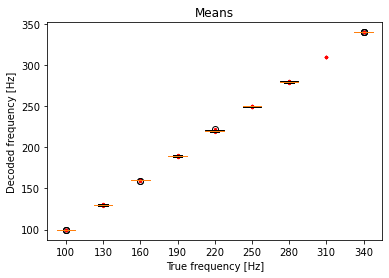

In [139]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# If a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(means_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, means_organized, s=5, c='r')

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Means")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


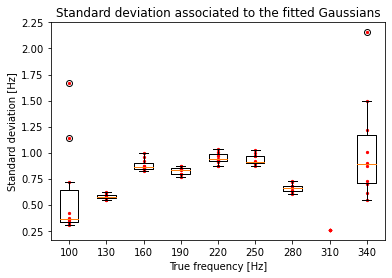

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


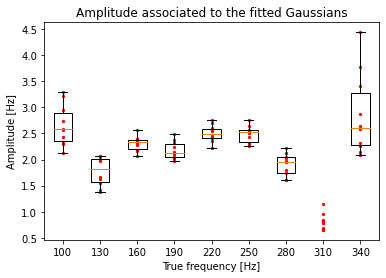

In [140]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()
ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, sigmas_organized, s=5, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)
# plt.ylim([-1, 5])
plt.hlines(np.mean(sigmas_organized), 0, 9, linestyle='dashed', colors = 'r')

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Standard deviation [Hz]')
plt.title("Standard deviation associated to the fitted Gaussians")
plt.show()

# Amplitudes
fig, ax = plt.subplots()
ax.boxplot(amplitudes_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, amplitudes_organized, s=5, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)
# plt.ylim([-1, 5])
plt.hlines(np.mean(amplitudes_organized), 0, 9, linestyle='dashed', colors = 'r')

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(tactile_stimuli[i]) for i in range(len(tactile_stimuli))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Amplitude [Hz]')
plt.title("Amplitude associated to the fitted Gaussians")
plt.show()

In [ ]:
# Amplitudes graph.

In [ ]:
# HERE overlaying the 10 stimulus conditions on a single plot.

### Code in the following cells should help with the plot to overlay the stim conditions. But you'd have to modify the xdata and ydata values.

# Bugs during the last week of August:
- The average of a vector with NaNs is always NaN.
- GAUSSIANS ARE TRANSLATED BY 100 IN THE X ACIS. THE ORIGINAL SPACE IS NOT 0-240. IT IS 100-340 HZ!! Consequence: Negative amplitudes.

Note `means_organized` are in the space of 100-340 Hz.

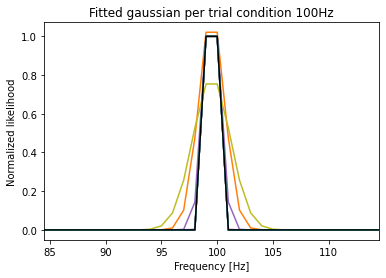

In [145]:
stim_i = 0
for rep_i in range(len(means_organized[stim_i])):
    mean = means_organized[stim_i][rep_i]
    sigma = sigmas_organized[stim_i][rep_i]
    amplitude = amplitudes_organized[stim_i][rep_i]

    y_ind = gaussian(xdata, mean, sigma, amplitude)    
    plt.plot(xdata, y_ind)   

yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)

plt.plot(xdata, yy, c='k')
plt.xlim([mean-15, mean+15])
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Normalized likelihood')
plt.title("Fitted gaussian per trial condition "+str(stimuli_organized[stim_i][0])+"Hz")

plt.show()

# WTF. Negative amplitudes??

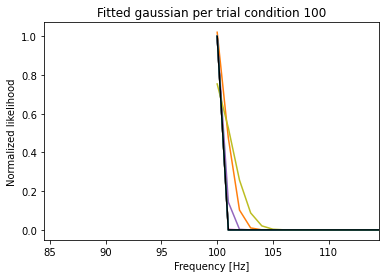

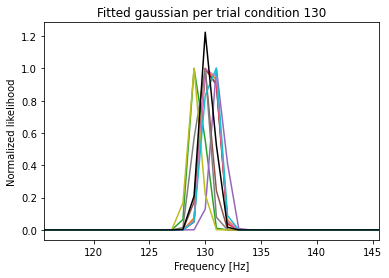

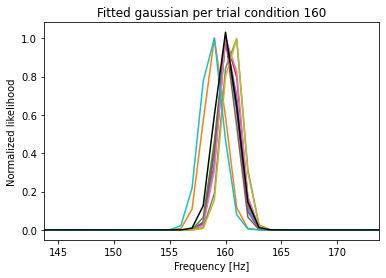

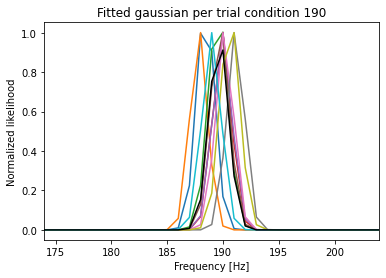

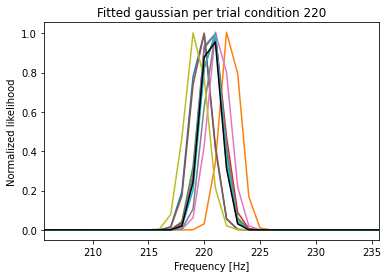

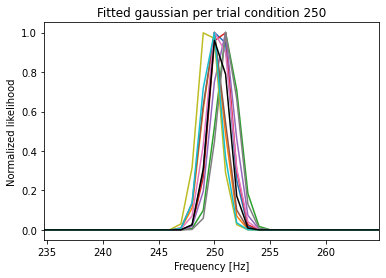

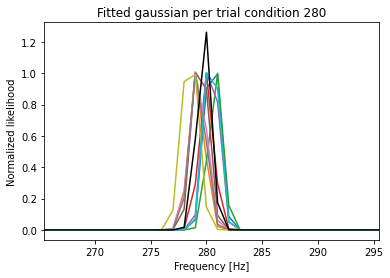

NaNs present in frequency  310 Hz.


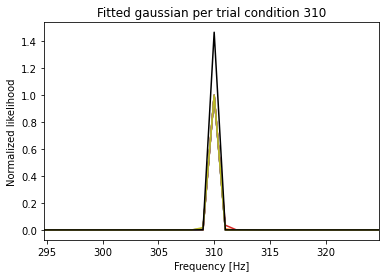

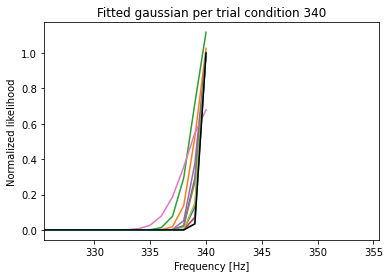

In [146]:
# PLotting the overlayed lots for every stimulus condition.

for stim_i in range(len(means_organized)):
    xdata = [i+100 for i in range(nfrequencies)]
    
    if np.isnan(np.min(means_organized[stim_i])):
        print("NaNs present in frequency ",stimuli_organized[stim_i][0],"Hz.")
        
        # Remove isnans
        # https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
        means_organized[stim_i] = means_organized[stim_i][~np.isnan(means_organized[stim_i])]
        sigmas_organized[stim_i] = sigmas_organized[stim_i][~np.isnan(sigmas_organized[stim_i])]
        amplitudes_organized[stim_i] = amplitudes_organized[stim_i][~np.isnan(amplitudes_organized[stim_i])]

    mean = np.mean(means_organized[stim_i])
    sigma = np.mean(sigmas_organized[stim_i])
    amplitude = np.mean(amplitudes_organized[stim_i])
    
    for rep_i in range(len(means_organized[stim_i])):
        mean = means_organized[stim_i][rep_i]
        sigma = sigmas_organized[stim_i][rep_i]
        amplitude = amplitudes_organized[stim_i][rep_i]

        y_ind = gaussian(xdata, mean, sigma, amplitude)    
        plt.plot(xdata, y_ind)   

    yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)

    plt.plot(xdata, yy, c='k')
    plt.xlim([mean-15, mean+15])
    plt.xlabel(r'Frequency [Hz]')
    plt.ylabel(r'Normalized likelihood')
    plt.title("Fitted gaussian per trial condition "+str(stimuli_organized[stim_i][0]))

    plt.show()

## Are the differences across sigmas significant? Because they shouldn't be. What is the proportion of false positives?

## Copied and pasted from the Distributions_and_false_positives notebook

## Statistics

Two sample test:

$$t = \frac{\vec{X}_1 - \vec{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

### Note this test is not invariant under a linear transformation! So if we fit an amplitude term to the gaussian, we will obtain different t values!!

In [ ]:
stimuli_1 = [i*30+100 for i in range(nStimuli)]
stimuli_short = stimuli_1[1:7] # Taking out the elements in the boundaries

In [ ]:
# Perform two-sample t-test

# for i in range(len(stimuli_1)):
#     for k in range(i, len(stimuli_1)):
#         t_statistic, p_value = ttest_ind(sigmas_organized[i], sigmas_organized[k])
#         if p_value < 0.05:
#             print("There is a statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
            
            
# Perform two-sample t-test
false_positives_counter = 0
counter = 0
for i in range(len(stimuli_short)):
    for k in range(i, len(stimuli_short)):
        t_statistic, p_value = ttest_ind(sigmas_organized[i], sigmas_organized[k])
        counter +=1
        if p_value < 0.05:
            print("p=",p_value,". Statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
            false_positives_counter += 1
print(false_positives_counter/counter)

Naïvely, I think there should be no statistical difference in the data since it all comes from the same kind of sampling of the same artificial neurons. But maybe if there is a statistical difference it is because a small $n$.

In [ ]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()
ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, sigmas_vec, s=5, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)
# plt.ylim([-1, 5])
plt.hlines(np.mean(sigmas_organized[1:7]), 0, 9, linestyle='dashed', colors = 'r')

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
# labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(stimuli_1[i]) for i in range(len(stimuli_1))]
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Standard deviation [Hz]')
plt.title("Standard deviation associated to the fitted Gaussians")
plt.show()

J: Plot the fitted gaussians across frequency.

If there is a significant difference across the sigmas, where is this coming from?

Another idea is to overlay all the gaussians at 0 and see their spread.

Play around with the noise level noise. If you increase it, does the decoding break? What does it mean for this model break?

What if we double the voxels?

Play with the number of trials. Instead of 20, 2.

In [ ]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(amplitudes_organized)#, notch=True, labels = stimuli_1)
# plt.scatter(stimuli_1, means_organized)
plt.scatter(stimuli_aux, amplitudes_vec, s=5, c='r')
# plt.scatter(stimuli_test, means_vec, s=5)
# plt.ylim([-1, 5])

plt.hlines(np.mean(amplitudes_organized[1:7]), 0, 9, linestyle='dashed', colors = 'r')

# plt.ylim([20, 28])
# plt.xlim([1.5, 2.5])

# Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(stimuli_1[i]) for i in range(len(stimuli_1))]
ax.set_xticklabels(labels)

plt.xlabel(r'True $\theta$ [deg]')
plt.ylabel(r'Fitted amplitude')
plt.title("Amplitudes associated to the fitted Gaussians")
plt.show()

## Note how the amplitudes have the same trend as the standard deviations. But, the y scale is different.

In [ ]:
# Perform two-sample t-test
# This loop should only be the upper traingle or lower one of the matrix.
# Right now it is doing more than 2 times the necessary computations.

for i in range(len(stimuli_1)):
    for k in range(i, len(stimuli_1)):
        t_statistic, p_value = ttest_ind(amplitudes_organized[i], amplitudes_organized[k])
        if p_value < 0.05:
            print("There is a statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
# print(t_statistic)
# print(p_value)

# Note. Statistical tests are not invariant under linear transformations.

# Next steps. Accessing the database. NB pg 11.

Carlos Mendez, department IT person. Carlos.Mendez@bcm.